In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

%matplotlib inline

In [61]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

transform_ds = transforms.Compose([transforms.ToTensor()])

train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform_ds)
test_ds = datasets.MNIST(root="data", train=False, download=True, transform=transform_ds)

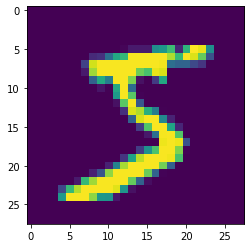

In [62]:
plt.imshow(train_ds.data[0].numpy())

In [63]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

# Check size
d = iter(train_loader).next()
d[0].shape

torch.Size([32, 1, 28, 28])

In [96]:
# Declare Network
class LinearAutoencoder(nn.Module):
    
    def __init__(self) -> None:
        super(LinearAutoencoder, self).__init__()
        self.linear1 = nn.Linear(784, 320)
        self.linear2 = nn.Linear(320, 64)
        self.linear3 = nn.Linear(64, 320)
        self.linear4 = nn.Linear(320, 784)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #x = x.view(-1, 784)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = torch.sigmoid(self.linear4(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearAutoencoder().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)


In [97]:
# Train Network
epochs = 30

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, _ in train_loader:
        inputs = inputs.view(-1, 784).to(device)
        optimizer.zero_grad()
        output = model.forward(inputs)
        loss = criterion(output, inputs)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    else:
        train_loss /= len(train_loader.dataset)
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        test_loss = 0
        for inputs, _ in test_loader:
            inputs = inputs.view(-1, 784).to(device)
            output = model.forward(inputs)
            loss = criterion(output, inputs)
            test_loss += loss.item()
        else:
            test_loss /= len(test_loader.dataset)
    
    scheduler.step()
    
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.6f} | Test loss: {test_loss:.6f}")


Epoch: 1 | Train loss: 17.480166 | Test loss: 8.291100
Epoch: 2 | Train loss: 7.185260 | Test loss: 6.107260
Epoch: 3 | Train loss: 5.646713 | Test loss: 5.116842
Epoch: 4 | Train loss: 4.892870 | Test loss: 4.608519
Epoch: 5 | Train loss: 4.456796 | Test loss: 4.362172
Epoch: 6 | Train loss: 4.172776 | Test loss: 4.060395
Epoch: 7 | Train loss: 3.980330 | Test loss: 3.936950
Epoch: 8 | Train loss: 3.835231 | Test loss: 3.797913
Epoch: 9 | Train loss: 3.728770 | Test loss: 3.729015
Epoch: 10 | Train loss: 3.645793 | Test loss: 3.675801
Epoch: 11 | Train loss: 3.581123 | Test loss: 3.617840
Epoch: 12 | Train loss: 3.529260 | Test loss: 3.575839
Epoch: 13 | Train loss: 3.489502 | Test loss: 3.537868
Epoch: 14 | Train loss: 3.457226 | Test loss: 3.508524
Epoch: 15 | Train loss: 3.432127 | Test loss: 3.488966
Epoch: 16 | Train loss: 3.411711 | Test loss: 3.478065
Epoch: 17 | Train loss: 3.394687 | Test loss: 3.466264
Epoch: 18 | Train loss: 3.381745 | Test loss: 3.455535
Epoch: 19 | Train 

In [80]:
indexes = np.random.randint(0, len(test_ds), size=10)

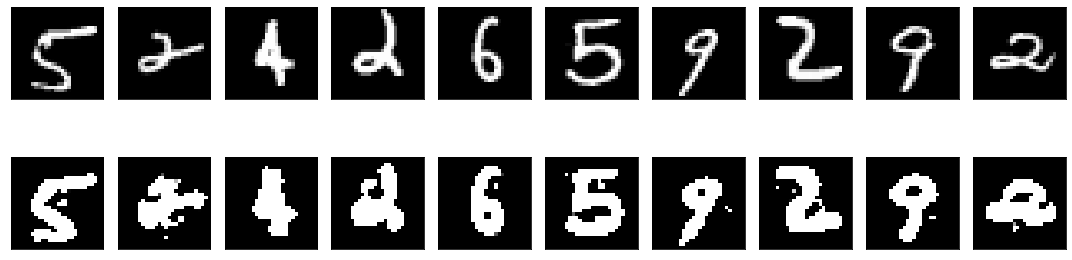

In [98]:
# Checking result
model.eval()
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(15, 5), sharex=True, sharey=True)
for idx, item in enumerate(indexes):
    picture = train_ds.data[item]
    ax[0][idx].imshow(picture.numpy(), cmap='gray')
    result = model.forward(picture.view(-1, 784).to(device=device, dtype=torch.float))
    ax[1][idx].imshow(result.view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[0][idx].get_xaxis().set_visible(False)
    ax[0][idx].get_yaxis().set_visible(False)
    ax[1][idx].get_xaxis().set_visible(False)
    ax[1][idx].get_yaxis().set_visible(False)

plt.tight_layout()